In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

from wordcloud import WordCloud
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'sms-spam-collection-dataset' dataset.
Path to dataset files: /kaggle/input/sms-spam-collection-dataset
['spam.csv']


## Load Data

In [3]:
df = pd.read_csv(path + '/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


,0
v1,0
v2,0
Unnamed: 2,5522
Unnamed: 3,5560
Unnamed: 4,5566


rename columns

In [5]:
df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df.head()

,label,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


drop Unnamed column

In [6]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


add length message columns

In [7]:
df['message_length'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,label,message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


## EDA

label distribusi

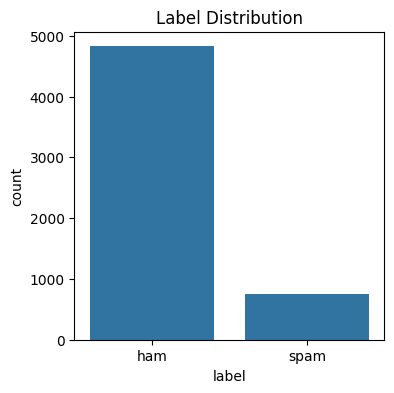

,count
label,
ham,4825
spam,747


In [8]:
plt.figure(figsize=(4,4))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.show()

df.label.value_counts()

panjang teks per label

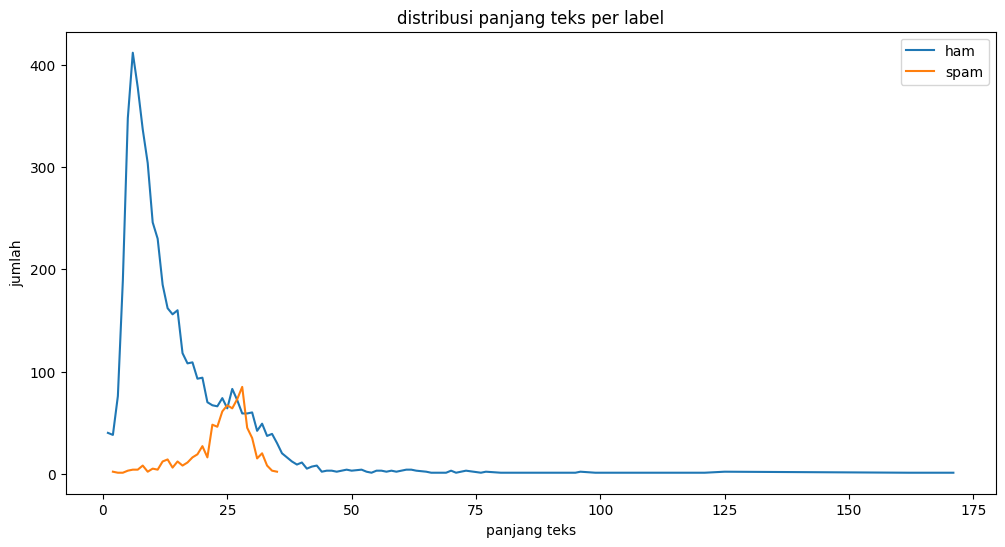

In [9]:
ham_df = df[df['label'] == 'ham']['message_length'].value_counts().sort_index()
spam_df = df[df['label'] == 'spam']['message_length'].value_counts().sort_index()


plt.figure(figsize=(12,6))
plt.plot(ham_df.index, ham_df.values, label='ham')
plt.plot(spam_df.index, spam_df.values, label='spam')
plt.title('distribusi panjang teks per label')
plt.xlabel('panjang teks')
plt.ylabel('jumlah')
plt.legend()
plt.show()

contoh spam n ham

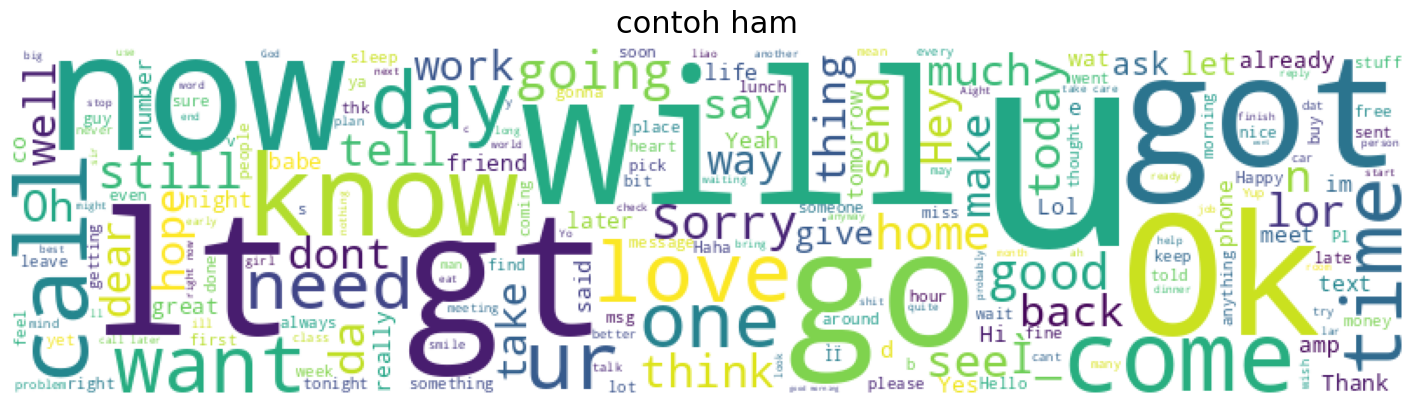

In [10]:
wc = WordCloud(
    background_color='white',
    width = 800
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'ham', 'message']))
plt.figure(figsize=(18,10))
plt.title('contoh ham',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

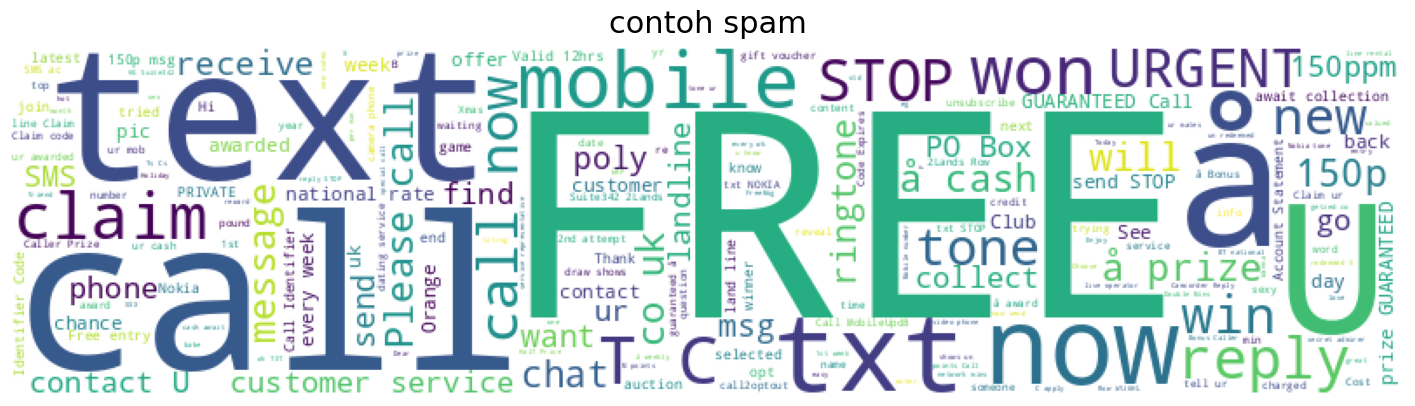

In [11]:
wc = WordCloud(
    background_color='white',
    width = 800,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'spam', 'message']))
plt.figure(figsize=(18,10))
plt.title('contoh spam',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

## Preprocess

cleaning text

In [12]:
def clean_message(text):
  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

In [13]:
df['clean_msg'] = df['message'].apply(lambda x: clean_message(x))
df.head()

,label,message,message_length,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


stopwords

In [14]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
  text = ' '.join([word for word in str(text).split() if word not in stop_words])
  return text

df['clean_msg'] = df['clean_msg'].apply(lambda x: remove_stopwords(x))
df.head()

,label,message,message_length,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


stemming

In [15]:
stemmer = nltk.SnowballStemmer("english")

def stem_text(text):
  text = ' '.join(stemmer.stem(word) for word in text.split(' '))
  return text

df['clean_msg'] = df['clean_msg'].apply(lambda x: stem_text(x))
df.head()

,label,message,message_length,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


encoding label

In [16]:
le = LabelEncoder()
le.fit(df['label'])

df['label'] = le.fit_transform(df['label'])
df.head()

,label,message,message_length,clean_msg
0,0,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts may...
3,0,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


token visual

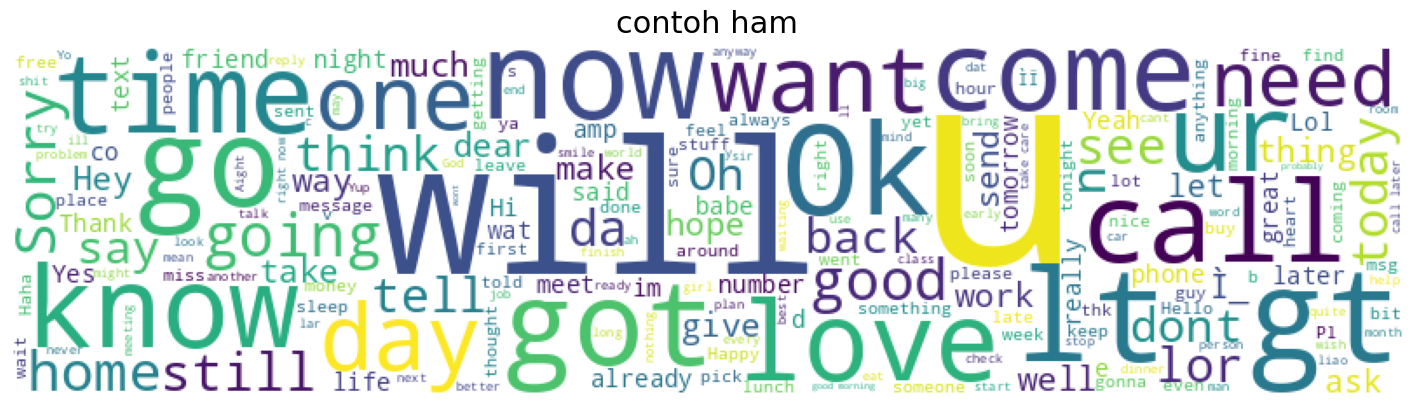

In [17]:
wc = WordCloud(
    background_color='white',
    width = 800,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 0, 'message']))
plt.figure(figsize=(18,10))
plt.title('contoh ham',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

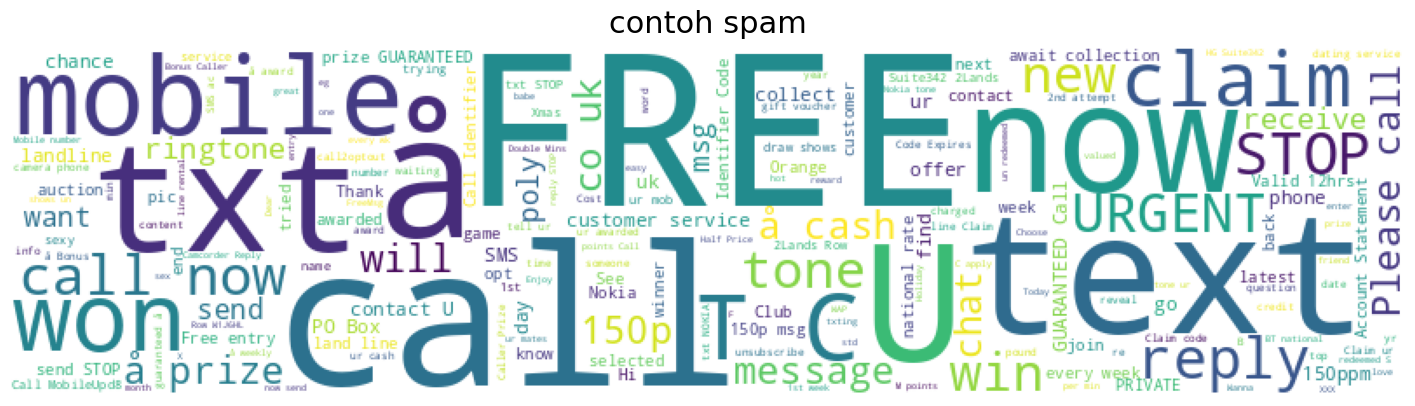

In [18]:
wc = WordCloud(
    background_color='white',
    width = 800,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 1, 'message']))
plt.figure(figsize=(18,10))
plt.title('contoh spam',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

## Train model

split data

In [22]:
X = df['clean_msg']
y = df['label']

X_test, X_train, y_test, y_train = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42)

In [24]:
vectorizer = CountVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [28]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

MultinomialNB()

In [29]:
y_pred = nb.predict(X_test_vec)

In [44]:
akurasi = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Akurasi: {akurasi:.3f}')
print(f'f1 : {f1:.3f}')
print(f'precision : {precision:.3f}')
print(f'recall : {recall:.3f}')

Akurasi: 0.975
f1 : 0.905
precision : 0.919
recall : 0.891


In [33]:
cr = classification_report(y_test, y_pred)

print(cr)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3860
           1       0.92      0.89      0.90       597

    accuracy                           0.97      4457
   macro avg       0.95      0.94      0.95      4457
weighted avg       0.97      0.97      0.97      4457



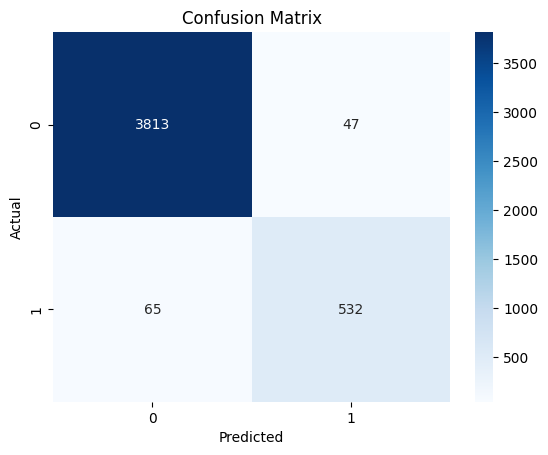

In [35]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

ROC AUC

In [37]:
y_proba = nb.predict_proba(X_test_vec)[:, 1]

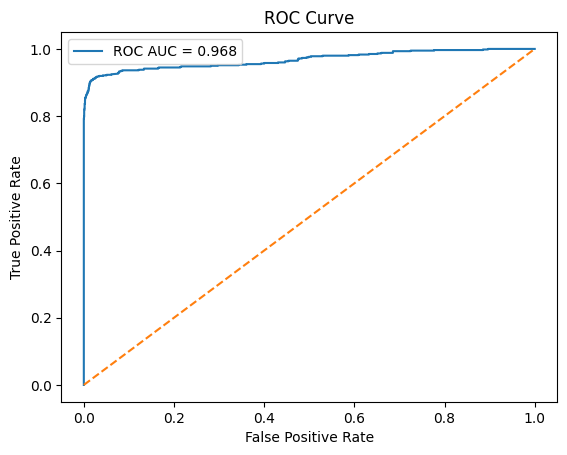

In [38]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

precision recall

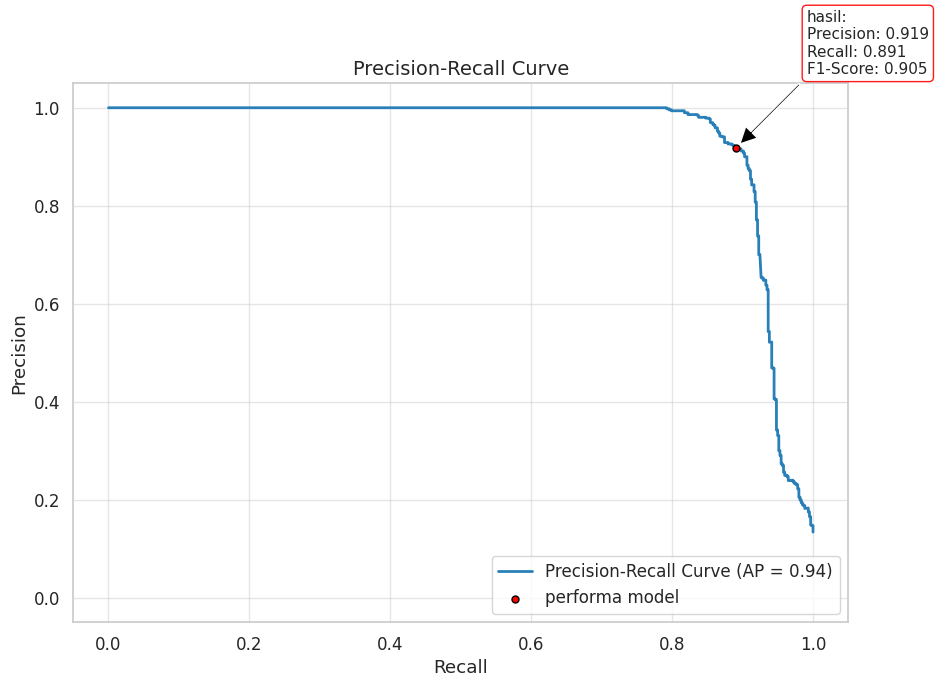

In [45]:
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)

current_recall = recall_score(y_test, y_pred)
current_precision = precision_score(y_test, y_pred)
current_f1 = f1_score(y_test, y_pred)

sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(10, 7))

#a
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall Curve (AP = {ap_score:.2f})',
         linewidth=2, color='#2980b9')

#b
plt.scatter(current_recall, current_precision, marker='o', color='red', s=25,
            label='performa model', zorder=5, edgecolors='black')

#c
text_label = (f"hasil:\n"
              f"Precision: {current_precision:.3f}\n"
              f"Recall: {current_recall:.3f}\n"
              f"F1-Score: {current_f1:.3f}")

plt.annotate(text_label,
             xy=(current_recall, current_precision),
             xytext=(current_recall + 0.1, current_precision + 0.15),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9),
             fontsize=11)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc='lower right')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(True, alpha=0.5)

plt.show()